# xml -> annotation

In [2533]:
DATA_PATH=f"../data"
MODEL_PATH=f"../model"
IMAGE_PATH=f"../images/"

DATA_FEATURE_PATH=f"{DATA_PATH}/processed-feature"
DATA_RAW_PATH=f"{DATA_PATH}/raw"
DATA_TEST_PATH=f"{DATA_PATH}/test"

OSMD="osmd-dataset-v1.0.0"

SEQ_ANNO="sequence-annotation"


xml_path = f'{DATA_RAW_PATH}/{OSMD}/Rock-ver/Rock-ver.xml'
dataset_path = f'{DATA_FEATURE_PATH}/{SEQ_ANNO}/Rock-ver/'

# 학습!!!

In [2534]:
import os 
import numpy as np 
import matplotlib.pyplot as plt 
from pathlib import Path 
from collections import Counter 
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers

import glob
import re

import albumentations as alb
from albumentations.pytorch import ToTensorV2

In [2535]:
# 배치 사이즈 지정
batch_size = 16

# 이미지 크기 지정
img_width = 256
img_height = 128


# 제일 긴 라벨 길이
max_length = 24

In [2536]:
import os
from omegaconf import OmegaConf


def getconfig(configpath):
    args = OmegaConf.load(configpath)

    workspace = os.path.dirname(configpath)
    for key in args.filepaths.keys():
        args.filepaths[key] = os.path.join(workspace, args.filepaths[key])
    return args


In [2537]:
# 각 token에 맞는 string list로 만들기
def map_pitch(note):
    pitch_mapping = {
        "nonote": 0,
        "note-D4": 1,
        "note-E4": 2,
        "note-F4": 3,
        "note-G4": 4,
        "note-A4": 5,
        "note-B4": 6,
        "note-C5": 7,
        "note-D5": 8,
        "note-E5": 9,
        "note-F5": 10,
        "note-G5": 11,
        "note-A5": 12,
        "note-B5": 13,
        "<unk>" : 14
    }
    return "nonote" if note not in pitch_mapping else note

def map_rhythm(note):
    duration_mapping =  {
        "[PAD]":0,
        "+": 1,
        "|": 2,
        "barline": 3,
        "clef-percussion": 4,

        "note-eighth": 5,
        "note-eighth.": 6,
        "note-half": 7,
        "note-half.": 8,

        "note-quarter": 9,
        "note-quarter.": 10,
        "note-16th": 11,
        "note-16th.": 12,

        "note-whole": 13,
        "note-whole.": 14,

        "rest-eighth": 15,
        "rest-eighth.": 16,
        "rest-half": 17,
        "rest-half.": 18,

        "rest-quarter": 19,
        "rest-quarter.": 20,
        "rest-16th": 21,
        "rest-16th.": 22,

        "rest-whole": 23,
        "rest-whole.": 24,
        
        "timeSignature-4/4": 25
    }
    return note if note in duration_mapping else "<unk>"

def map_lift(note):
    lift_mapping =  {
        # "nonote"    : 0,
        "lift_null" : 1,
        "lift_##"   : 2,
        "lift_#"    : 3,
        "lift_bb"   : 4,
        "lift_b"    : 5,
        "lift_N"    : 6
    }
    return "nonote" if note not in lift_mapping else note
    
def symbol2pitch_rhythm_lift(symbol_lift, symbol_pitch, symbol_rhythm):
    return map_lift(symbol_lift), map_pitch(symbol_pitch), map_rhythm(symbol_rhythm)

def note2pitch_rhythm_lift(note):
    # note-G#3_eighth
    note_split = note.split("_") # (note-G#3) (eighth)
    note_pitch_lift = note_split[:1][0]
    note_rhythm = note_split[1:][0]
    rhythm=f"note-{note_rhythm}"
    # print("-- note_rhythm: ", rhythm)

    note_note, pitch_lift = note_pitch_lift.split("-") # (note) (G#3)
    if len(pitch_lift)>2:
        pitch = f"note-{pitch_lift[0]+pitch_lift[-1]}" # (G3)
        lift = f"lift_{pitch_lift[1:-1]}"
    else:
        pitch = f"note-{pitch_lift}" 
        lift = f"lift_null"
    # print("-- note_pitch_lift: ", pitch, lift)
    return symbol2pitch_rhythm_lift(lift, pitch, rhythm)

def rest2pitch_rhythm_lift(rest):
    # rest-quarter
    return symbol2pitch_rhythm_lift("nonote", "nonote", rest)

def map_pitch2isnote(pitch_note):
    group_notes = []
    note_split = pitch_note.split("+")
    for note_s in note_split:
        if "nonote" in note_s:
            group_notes.append("nonote")
        elif "note-" in note_s:
            group_notes.append("note")
    return "+".join(group_notes)


def map_notes2pitch_rhythm_lift_note(note_list):
    result_lift=[]
    result_pitch=[]
    result_rhythm=[]
    result_note=[]

    for notes in note_list:
        group_lift = []
        group_pitch = []
        group_rhythm = []
        group_notes_token_len=0

        # 우선 +로 나누고, 안에 | 있는 지 확인해서 먼저 붙이기
        # note-G#3_eighth + note-G3_eighth + note-G#3_eighth|note-G#3_eighth + rest-quarter
        note_split = notes.split("+")
        for note_s in note_split:
            if "|" in note_s:
                mapped_lift_chord = []
                mapped_pitch_chord = []
                mapped_rhythm_chord = []
                
                # note-G#3_eighth|note-G#3_eighth
                note_split_chord = note_s.split("|") # (note-G#3_eighth) (note-G#3_eighth)
                for idx, note_s_c in enumerate(note_split_chord):
                    chord_lift, chord_pitch, chord_rhythm = note2pitch_rhythm_lift(note_s_c)

                    mapped_lift_chord.append(chord_lift)
                    mapped_pitch_chord.append(chord_pitch)
                    mapped_rhythm_chord.append(chord_rhythm)

                    # --> '|' 도 token이기 때문에 lift, pitch엔 nonote 추가해주기
                    if idx != len(note_split_chord)-1:
                        mapped_lift_chord.append("nonote")
                        mapped_pitch_chord.append("nonote")

                group_lift.append("+".join(mapped_lift_chord))
                group_pitch.append("+".join(mapped_pitch_chord))
                group_rhythm.append(" | ".join(mapped_rhythm_chord))

                # --> '|' 도 token이기 때문에 추가된 token 개수 더하기
                # 동시에 친 걸 하나의 string으로 해버리는 거니까 주의하기
                group_notes_token_len+=len(note_split_chord) + len(note_split_chord)-1

            elif "note" in note_s:
                if "_" in note_s:
                    # note-G#3_eighth
                    note2lift, note2pitch, note2rhythm = note2pitch_rhythm_lift(note_s)
                    group_lift.append(note2lift)
                    group_pitch.append(note2pitch)
                    group_rhythm.append(note2rhythm)
                    group_notes_token_len+=1
            
            elif "rest" in note_s:
                if "-" in note_s:
                    # rest-quarter
                    rest2lift, rest2pitch, rest2rhythm =rest2pitch_rhythm_lift(note_s)
                    group_lift.append(rest2lift)
                    group_pitch.append(rest2pitch)
                    group_rhythm.append(rest2rhythm)
                    group_notes_token_len+=1
            else:
                # clef-F4+keySignature-AM+timeSignature-12/8
                symbol2lift, symbol2pitch, symbol2rhythm = symbol2pitch_rhythm_lift("nonote", "nonote", note_s)
                group_lift.append(symbol2lift)
                group_pitch.append(symbol2pitch)
                group_rhythm.append(symbol2rhythm)
                group_notes_token_len+=1

        toks_len= group_notes_token_len

        # lift, pitch
        # emb_lift="nonote+"
        # emb_pitch="nonote+"
        
        emb_lift= " ".join(group_lift)
        emb_pitch= " ".join(group_pitch)
        # emb_lift+="+nonote"
        # emb_pitch+="+nonote"

        # rhythm
        # emb_rhythm="[BOS]"
        emb_rhythm= " ".join(group_rhythm)
        # emb_rhythm+="[EOS]"

        # 뒤에 남은 건 패딩
        if toks_len < max_length :
            for _ in range(max_length - toks_len ):
                emb_lift+="+nonote"
                emb_pitch+="+nonote"        
                emb_rhythm+=" [PAD]"

        result_lift.append(emb_lift)
        result_pitch.append(emb_pitch)
        result_rhythm.append(emb_rhythm)
        result_note.append(map_pitch2isnote(emb_pitch))
    return result_lift, result_pitch, result_rhythm, result_note

In [2538]:
"""
우선 문자를 숫자로 encoding 해주고 숫자를 문자로 decoding 해주기 위한
char_to_num과 num_to_char를 만들어주겠습니다.
"""

from transformers import PreTrainedTokenizerFast
import torch

cofigpath = "../src/workspace/config-drum.yaml"
args = getconfig(cofigpath)


lifttokenizer = PreTrainedTokenizerFast(
            tokenizer_file=args.filepaths.lifttokenizer
        )
pitchtokenizer = PreTrainedTokenizerFast(
    tokenizer_file=args.filepaths.pitchtokenizer
)
rhythmtokenizer = PreTrainedTokenizerFast(
    tokenizer_file=args.filepaths.rhythmtokenizer
)
notetokenizer = PreTrainedTokenizerFast(
    tokenizer_file=args.filepaths.notetokenizer
)
transform = alb.Compose(
    [
        alb.ToGray(always_apply=True),
        alb.Normalize((0.7931, 0.7931, 0.7931), (0.1738, 0.1738, 0.1738)),
        ToTensorV2(),
    ]
)

In [2539]:
char_to_int_mapping = [
    "|",                # 0
    "barline",          # 1
    "clef-percussion",  # 2
    "note-eighth",      # 3
    "note-eighth.",     # 4
    "note-half",        # 5
    "note-half.",       # 6
    "note-quarter",     # 7
    "note-quarter.",    # 8
    "note-16th",   # 9
    "note-16th.",  # 10
    "note-whole",       # 11
    "note-whole.",      # 12
    "rest-eighth",      # 13
    "rest-eighth.",     # 14
    "rest-half",        # 15
    "rest-half.",       # 16
    "rest-quarter",     # 17
    "rest-quarter.",    # 18
    "rest-16th",   # 19
    "rest-16th.",  # 20
    "rest-whole",       # 21
    "rest-whole.",      # 22
    "timeSignature-4/4" # 23
]


# 문자를 숫자로 변환
char_to_num = layers.StringLookup(
    vocabulary=list(char_to_int_mapping), mask_token=None
)
print(char_to_num.get_vocabulary())
test=["clef-percussion","note-eighth","|","note-eighth", "note-eighth", "note-eighth|note-eighth"]
print(char_to_num(test))

# 숫자를 문자로 변환
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

['[UNK]', '|', 'barline', 'clef-percussion', 'note-eighth', 'note-eighth.', 'note-half', 'note-half.', 'note-quarter', 'note-quarter.', 'note-16th', 'note-16th.', 'note-whole', 'note-whole.', 'rest-eighth', 'rest-eighth.', 'rest-half', 'rest-half.', 'rest-quarter', 'rest-quarter.', 'rest-16th', 'rest-16th.', 'rest-whole', 'rest-whole.', 'timeSignature-4/4']
tf.Tensor([3 4 1 4 4 0], shape=(6,), dtype=int64)


In [2540]:
def read_txt_file(file_path):
    """
    텍스트 파일을 읽어서 내용을 리스트로 반환하는 함수
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.readlines()
        # 각 줄의 개행 문자 제거
        content = [line.strip() for line in content]
    return content[0]


In [2541]:
import cv2
import torch
import numpy as np

def readimg(path):

    img = cv2.imread(path)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # -- 설정 임곗값(retval), 결과 이미지(biImg)
    ret, biImg = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV) # -- 임곗값을 초과할 경우 0, 아닐 경우 maxval
    img=biImg


    # h, w, c = img.shape
    # new_h = img_height
    # new_w = int(img_height / h * w)
    # new_w = new_w // 16 * 16
    img = cv2.resize(img, (img_width, img_height))
    # img = transform(image=img)["image"][:1]

    print(f"2 -- resize 후")
    print(img.shape)
    print(img.dtype)
    return img

In [2542]:
# 데이터셋 경로 지정

# # 이미지, 라벨, 각 문자를 담은 리스트 생성
# images = sorted(list(map(str, list(data_dir.glob("*.png")))))
# labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
# characters = set(char for label in labels for char in label)


# x_dataset_path=f"{dataset_path}"
# x_all_dataset_path = glob.glob(f"{x_dataset_path}/*")
# x_pattern = re.compile(r'^[^._].*\.png$') 
# y_pattern = re.compile(r'^[^._].*\.txt$')

# x_raw_file_list=[]  # image
# y_raw_file_list=[]  # label
# for x_path in x_all_dataset_path:
#     files = os.listdir(x_path)
#     x_filtered_files = [f"{x_path}/{file}" for file in files if x_pattern.match(file)]
#     y_filtered_files = [f"{x_path}/{file}" for file in files if y_pattern.match(file)]
#     if len(x_filtered_files) == len(y_filtered_files):
#         x_raw_file_list+=x_filtered_files
#         y_raw_file_list+=y_filtered_files

# del x_all_dataset_path
# # print("x:",len(x_raw_file_list),x_raw_file_list)
# # print("y:",len(y_raw_file_list),y_raw_file_list)


x_dataset_path=f"{dataset_path}/measure/"
x_all_dataset_path = glob.glob(f"{x_dataset_path}/*")
x_file_list = [file for file in x_all_dataset_path if file.endswith(f".png")]
x_file_list.sort()

# imgpath = f"{DATA_TEST_PATH}/test-01.png"

y_dataset_path=f"{dataset_path}/annotation/"
y_all_dataset_path = glob.glob(f"{y_dataset_path}/*")
y_file_list = [file for file in y_all_dataset_path if file.endswith(f".txt")]
y_file_list.sort()



images = x_file_list
labels = y_file_list
print("총 이미지 개수: ", len(images), images)
print("총 라벨 개수: ", len(labels), labels)
# print("고유한 문자 개수: ", len(characters))
# print("라벨의 고유한 문자 확인: ", characters)

총 이미지 개수:  92 ['../data/processed-feature/sequence-annotation/Rock-ver//measure/Rock-ver_pad-stave-origin_10_2024-05-15_19-22-06.png', '../data/processed-feature/sequence-annotation/Rock-ver//measure/Rock-ver_pad-stave-origin_11_2024-05-15_19-22-06.png', '../data/processed-feature/sequence-annotation/Rock-ver//measure/Rock-ver_pad-stave-origin_12_2024-05-15_19-22-06.png', '../data/processed-feature/sequence-annotation/Rock-ver//measure/Rock-ver_pad-stave-origin_13_2024-05-15_19-22-06.png', '../data/processed-feature/sequence-annotation/Rock-ver//measure/Rock-ver_pad-stave-origin_14_2024-05-15_19-22-06.png', '../data/processed-feature/sequence-annotation/Rock-ver//measure/Rock-ver_pad-stave-origin_15_2024-05-15_19-22-06.png', '../data/processed-feature/sequence-annotation/Rock-ver//measure/Rock-ver_pad-stave-origin_16_2024-05-15_19-22-06.png', '../data/processed-feature/sequence-annotation/Rock-ver//measure/Rock-ver_pad-stave-origin_17_2024-05-15_19-22-06.png', '../data/processed-featur

In [2543]:
# # 문자를 숫자로 변환
# char_to_num = layers.StringLookup(
#     vocabulary=list(characters), mask_token=None
# )
def entokenize(state, token, tokenizer):
    return tokenizer.tokenize(token)

# # 숫자를 문자로 변환
# num_to_char = layers.StringLookup(
#     vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
# )
def detokenize(token, tokenizer):
    return tokenizer.convert_ids_to_tokens(token)

In [2544]:
# 각 파일의 내용을 담을 리스트
contents = []
# 각 파일을 읽어서 내용을 리스트에 추가
for annotation_path in labels:
    # print("--- annotation_path:", annotation_path)
    content = read_txt_file(annotation_path)
    # 사이사이에 + 로 연결해주기
    content=content.replace(" ","+")
    content=content.replace("\t","+")
    contents.append(content)

result_lift, result_pitch, result_rhythm, result_note = map_notes2pitch_rhythm_lift_note(contents)
print(len(result_lift), len(result_pitch), len(result_rhythm), len(result_note))

# label_result=[]
# for re in result_rhythm:
#     label_result.append(entokenize("rhythm", re, rhythmtokenizer))

# print(label_result)

labels=result_rhythm
print(labels)
print(len(labels))

92 92 92 92
['note-quarter | note-quarter note-eighth | note-eighth note-eighth note-eighth | note-eighth note-eighth | note-eighth note-eighth | note-eighth note-eighth barline [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', 'note-eighth | note-eighth note-eighth note-eighth | note-eighth note-eighth | note-eighth note-eighth note-eighth | note-eighth note-eighth | note-eighth note-eighth barline [PAD] [PAD] [PAD] [PAD] [PAD]', 'note-eighth | note-eighth note-eighth note-eighth | note-eighth note-eighth note-eighth | note-eighth note-eighth | note-eighth note-eighth | note-eighth note-eighth barline [PAD] [PAD] [PAD] [PAD] [PAD]', 'clef-percussion note-eighth | note-eighth note-eighth note-eighth | note-eighth note-eighth | note-eighth note-eighth | note-eighth note-eighth | note-eighth barline [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', 'note-quarter | note-quarter note-eighth | note-eighth note-eighth note-eighth | note-eighth note-eighth | note-eighth note-eighth | note-eighth note-eighth barline 

In [2545]:
# data를 train과 validation set으로 split
def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. 데이터 셋의 개수
    size = len(images)
    # 2. 데이터 셋의 인덱스를 저장하고 필요시 shuffle
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. train_size에 맞춰 train set 사이즈 결정
    train_samples = int(size * train_size)
    # 4. train, validation set 나눠주기
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]

    return x_train, x_valid, y_train, y_valid



In [2546]:
def encode_single_sample(img_path, label):
    # 1. 이미지 불러오기
    img = tf.io.read_file(img_path)
    # 2. 이미지로 변환하고 grayscale로 변환
    img = tf.io.decode_png(img, channels=1)
    # 3. [0,255]의 정수 범위를 [0,1]의 실수 범위로 변환
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. 이미지 resize
    img = tf.image.resize(img, [img_height, img_width])
    # 5. 이미지의 가로 세로 변환 
    # img = tf.image.flip_up_down(img)
    img = tf.transpose(img, perm=[1, 0, 2])
    # img = tf.image.flip_left_right(img) # 좌우반전
    
    # 6. 라벨 값의 문자를 숫자로 변환
    label_r = char_to_num(tf.strings.split(label))

    # 7. 딕셔너리 형태로 return
    return {"image": img, "label": label_r}


In [2547]:
# data를 trian set과 validation set으로 나누어 각 변수에 저장
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

print(x_train)
print(y_train)
# label_result=[]
# for re in y_train:
#     label_result.append(entokenize("rhythm", re, rhythmtokenizer))

# print(label_result)

# y_train=np.array(label_result)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))


# 잘 나눠졌는지 확인
# for aa in train_dataset.take(3):
#     print(aa)

train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# print("배치 후 >>>",train_dataset)
# <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 1000, 120, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}>

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

['../data/processed-feature/sequence-annotation/Rock-ver//measure/Rock-ver_pad-stave-origin_21_2024-05-15_19-22-06.png'
 '../data/processed-feature/sequence-annotation/Rock-ver//measure/Rock-ver_pad-stave-origin_70_2024-05-15_19-22-07.png'
 '../data/processed-feature/sequence-annotation/Rock-ver//measure/Rock-ver_pad-stave-origin_74_2024-05-15_19-22-07.png'
 '../data/processed-feature/sequence-annotation/Rock-ver//measure/Rock-ver_pad-stave-origin_35_2024-05-15_19-22-06.png'
 '../data/processed-feature/sequence-annotation/Rock-ver//measure/Rock-ver_pad-stave-origin_54_2024-05-15_19-22-06.png'
 '../data/processed-feature/sequence-annotation/Rock-ver//measure/Rock-ver_pad-stave-origin_42_2024-05-15_19-22-06.png'
 '../data/processed-feature/sequence-annotation/Rock-ver//measure/Rock-ver_pad-stave-origin_58_2024-05-15_19-22-07.png'
 '../data/processed-feature/sequence-annotation/Rock-ver//measure/Rock-ver_pad-stave-origin_1_2024-05-15_19-22-06.png'
 '../data/processed-feature/sequence-anno

tf.Tensor(
[[[[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  ...

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]]


 [[[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  ...

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]]


 [[[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  ...

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1

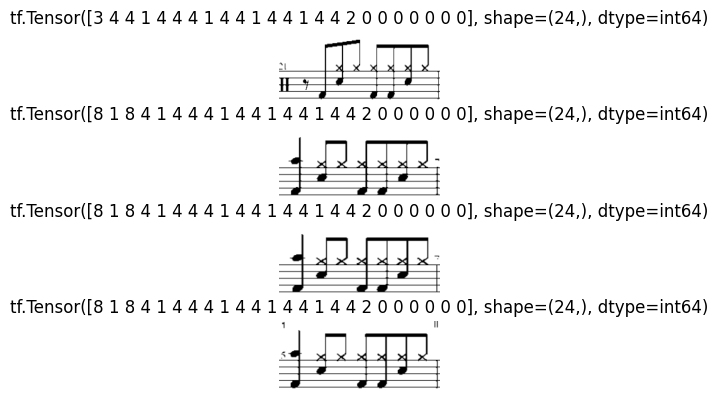

In [2548]:
_, ax = plt.subplots(4, 1)


for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    print(images)
    print(labels)

    for i in range(4):
        img = (images[i] * 255).numpy().astype("uint8")
        # label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        label=labels[i]
        print(labels[i])
        ax[i].imshow(img[:, :, 0].T, cmap="gray")
        ax[i].set_title(label)
        ax[i].axis("off")
plt.show()

# _, ax = plt.subplots(4, 4, figsize=(10, 5))
# for batch in train_dataset.take(1):
#     images = batch["image"]
#     labels = batch["label"]
#     for i in range(16):
#         img = (images[i] * 255).numpy().astype("uint8")
#         label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
#         ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
#         ax[i // 4, i % 4].set_title(label)
#         ax[i // 4, i % 4].axis("off")
# plt.show()

In [2549]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # 모델이 training 시, self.add_loss()를 사용하여 loss를 계산하고 더해줌
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # test시에는 예측값만 반환
        return y_pred


In [2550]:
def build_model():
    # Inputs 정의
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # 첫번째 convolution block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # 두번째 convolution block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # 앞에 2개의 convolution block에서 maxpooling(2,2)을 총 2번 사용
    # feature map의 크기는 1/4로 downsampling 됨
    # 마지막 레이어의 filter 수는 64개 다음 RNN에 넣기 전에 reshape 해줌
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # 위에서 지정한 CTCLayer 클래스를 이용해서 ctc loss를 계산
    output = CTCLayer(name="ctc_loss")(labels, x)

    # 모델 정의
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()

    # 모델 컴파일
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 256, 128, 1)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 256, 128, 32)         320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 128, 64, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 128, 64, 64)          18496     ['pool1[0][0]']               
                                                                                       

In [2551]:
epochs = 200
early_stopping_patience = 10
# early stopping 지정
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# 100epoch으로 모델 학습
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/200


6/6 [==============================] - 9s 380ms/step - loss: 96.8148 - val_loss: 58.9153
Epoch 2/200
6/6 [==============================] - 0s 40ms/step - loss: 51.0110 - val_loss: 45.0033
Epoch 3/200
6/6 [==============================] - 0s 40ms/step - loss: 41.9549 - val_loss: 43.3762
Epoch 4/200
6/6 [==============================] - 0s 40ms/step - loss: 39.5208 - val_loss: 42.5745
Epoch 5/200
6/6 [==============================] - 0s 39ms/step - loss: 37.7479 - val_loss: 40.5508
Epoch 6/200
6/6 [==============================] - 0s 40ms/step - loss: 36.2975 - val_loss: 38.9225
Epoch 7/200
6/6 [==============================] - 0s 40ms/step - loss: 35.9303 - val_loss: 38.5283
Epoch 8/200
6/6 [==============================] - 0s 40ms/step - loss: 34.3783 - val_loss: 36.1247
Epoch 9/200
6/6 [==============================] - 0s 38ms/step - loss: 33.4423 - val_loss: 36.3920
Epoch 10/200
6/6 [==============================] - 0s 39ms/step - loss: 32.3979 - val_loss: 34.2709
Epoch 11/2

In [2552]:
# 예측모델 만들기
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# 출력값을 디코딩하는 함수 지정(output은 숫자로 나오기 때문에 위에서 지정한 num_to_char를 이용해서 문자로 변환)
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    output_text = []
    for res in results:
        print(res)
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 256, 128, 1)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 256, 128, 32)      320       
                                                                 
 pool1 (MaxPooling2D)        (None, 128, 64, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 128, 64, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 64, 32, 64)        0         
                                                                 
 reshape (Reshape)           (None, 64, 2048)          0         
                                                                 
 dense1 (Dense)              (None, 64, 64)            1311

1/1 [==============================] - 1s 1s/step
tf.Tensor([ 4  1  4  4  4  1  4  4  1  4  4  4 10 10  2  0  0  0 -1 -1 -1 -1 -1 -1], shape=(24,), dtype=int64)
tf.Tensor([ 4  4  4  4 10 10  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1], shape=(24,), dtype=int64)
tf.Tensor([ 3  4  1  4  4  4  1  4  4  1  4  4  1  4  4  1  4  4  2  0  0 -1 -1 -1], shape=(24,), dtype=int64)
tf.Tensor([ 4  1  4  4  1  4  4  1  4  4  1  4  4  1  4  8  2  0 -1 -1 -1 -1 -1 -1], shape=(24,), dtype=int64)
tf.Tensor([ 4  1  4  4  1  4  4  1  4  4  1  4  4  1  4  8  1  8  2  0 -1 -1 -1 -1], shape=(24,), dtype=int64)
tf.Tensor([ 8  1  8  4  1  4  4  1  4  4  1  4  4  1  4  2  0  0  0 -1 -1 -1 -1 -1], shape=(24,), dtype=int64)
tf.Tensor([ 4  1  4  4  4  1  4  4  1  4  4  1  4  4  1  4  4  2  0  0  0 -1 -1 -1], shape=(24,), dtype=int64)
tf.Tensor([ 3  8  2  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1], shape=(24,), dtype=int64)
tf.Tensor([ 4  1  4  4  4  1  4  4  1  4  4  4  1  4  4  2  0 

IndexError: index 4 is out of bounds for axis 0 with size 4

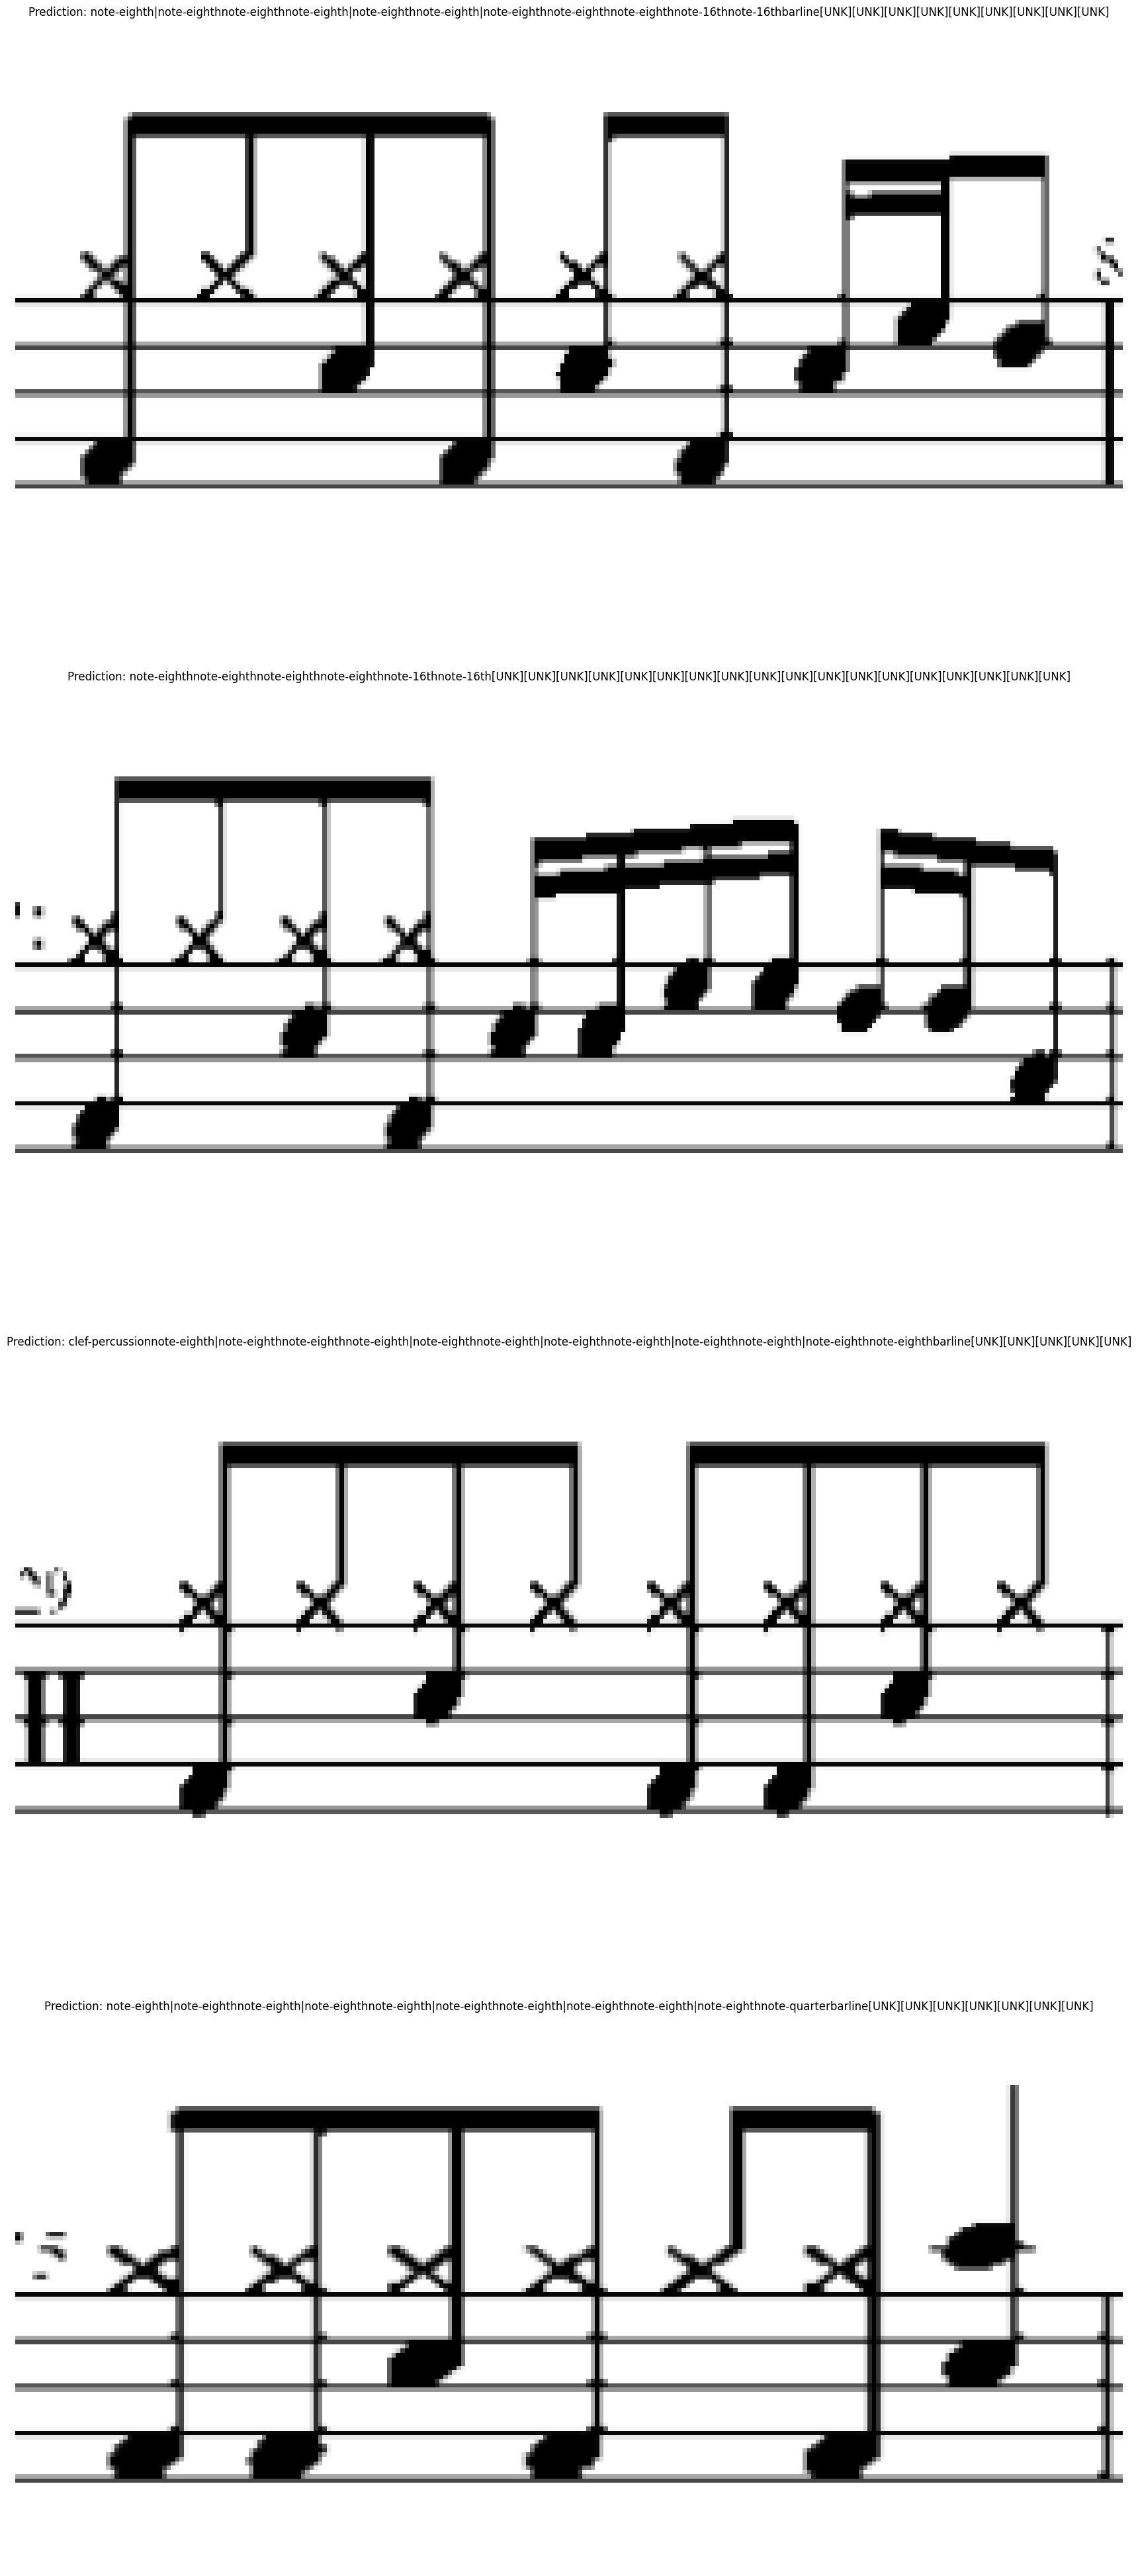

In [2553]:
#  validation dataset에서 하나의 배치를 시각화
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    # _, ax = plt.subplots(4, 4, figsize=(15, 5))
    _, ax = plt.subplots(4, 1, figsize=(100, 50))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i].imshow(img, cmap="gray")
        ax[i].set_title(title)
        ax[i].axis("off")
plt.show()